In [ ]:
import pickle

# load
with open('../data/NAVER_allpos_train.txt', 'rb') as rd:
    train_docs = pickle.load(rd)
    
with open('../data/NAVER_allpos_test.txt', 'rb') as rd:
    test_docs = pickle.load(rd)

In [1]:
with open('../data/NAVER_allpos_600_train.txt', 'rb') as rd:
    train_docs_600 = pickle.load(rd)
    
with open('../data/NAVER_allpos_600_test.txt', 'rb') as rd:
    test_docs_600 = pickle.load(rd)

In [ ]:
from collections import namedtuple

TaggedDocument = namedtuple('TaggedDocument', 'words tags')

tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

In [2]:
tagged_train_docs_600 = [TaggedDocument(d, [c]) for d, c in train_docs_600]
tagged_test_docs_600 = [TaggedDocument(d, [c]) for d, c in test_docs_600]

In [4]:
tagged_train_docs[0][0][-10:]

['미디어/Noun',
 '이데일리/Noun',
 '-/Punctuation',
 '무단/Noun',
 '전재/Noun',
 '&/Punctuation',
 '재/Noun',
 '배포/Noun',
 '금지/Noun',
 '＞/Foreign']

In [5]:
tagged_train_docs_600[0][0][-10:]

['마무리/Noun',
 '짓다/Verb',
 '해인/Noun',
 '만큼/Noun',
 '4/Number',
 '대다/Verb',
 '개혁/Noun',
 '의/Josa',
 '튼튼하다/Adjective',
 '받침/Noun']

---

In [6]:
from gensim.models import doc2vec

D2V_model = doc2vec.Doc2Vec.load('./Model/NAVER_ensemble_1')
D2V_600_model = doc2vec.Doc2Vec.load('./Model/NAVER_ensemble_2')

In [7]:
import numpy as np

train_x = [D2V_model.infer_vector(doc.words) for doc in tagged_train_docs]
train_y = [doc.tags[0] for doc in tagged_train_docs]

test_x = [D2V_model.infer_vector(doc.words) for doc in tagged_test_docs]
test_y = [doc.tags[0] for doc in tagged_test_docs]

train_x_np = np.asarray(train_x)
test_x_np = np.asarray(test_x)

In [8]:
train_x_600 = [D2V_600_model.infer_vector(doc.words) for doc in tagged_train_docs_600]
train_y_600 = [doc.tags[0] for doc in tagged_train_docs_600]

test_x_600 = [D2V_600_model.infer_vector(doc.words) for doc in tagged_test_docs_600]
test_y_600 = [doc.tags[0] for doc in tagged_test_docs_600]

train_x_np_600 = np.asarray(train_x_600)
test_x_np_600 = np.asarray(test_x_600)

In [22]:
labeling = train_y+test_y
labeling_np = np.asarray(labeling, dtype=str)

a , b = np.unique(labeling_np, return_inverse=True )
c , d = np.unique(labeling_np[160000:], return_counts=True )

train_label_np=a[b][:160000]
test_label_np=a[b][160000:]

train_y_np=b[:160000].astype(int)
test_y_np=b[160000:].astype(int)

In [23]:
labeling_600 = train_y_600 + test_y_600
labeling_np_600 = np.asarray(labeling_600, dtype=str)

a_600 , b_600 = np.unique(labeling_np_600, return_inverse=True )
c_600 , d_600 = np.unique(labeling_np_600[160000:], return_counts=True )

train_label_np_600 = a[b_600][:160000]
test_label_np_600 = a[b_600][160000:]

train_y_np_600 = b_600[:160000].astype(int)
test_y_np_600 = b_600[160000:].astype(int)

In [24]:
nb_classes = 48
train_y_np = np.eye(nb_classes)[train_y_np]
test_y_np = np.eye(nb_classes)[test_y_np]

In [25]:
nb_classes = 48
train_y_np_600 = np.eye(nb_classes)[train_y_np_600]
test_y_np_600 = np.eye(nb_classes)[test_y_np_600]

- - -

In [9]:
# Lab 10 MNIST and High-level TF API
import tensorflow.contrib as contrib
from tensorflow.contrib.layers import fully_connected, batch_norm, dropout, variance_scaling_initializer
from tensorflow.contrib.framework import arg_scope
import tensorflow as tf
import random
from datetime import datetime

In [20]:
# parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 64
keep_prob = 0.5
He = variance_scaling_initializer()

In [27]:
tf.reset_default_graph()

# input place holders
X = tf.placeholder(tf.float32, [None, 500])
Y = tf.placeholder(tf.float32, [None, 48])
train_mode = tf.placeholder(tf.bool, name='train_mode')

In [28]:
# fully_connected(
#     inputs,
#     num_outputs,
#     activation_fn=tf.nn.relu,
#     normalizer_fn=None,
#     normalizer_params=None,
#     weights_initializer=initializers.xavier_initializer(),
#     weights_regularizer=None,
#     biases_initializer=tf.zeros_initializer(),
#     biases_regularizer=None,
#     reuse=None,
#     variables_collections=None,
#     outputs_collections=None,
#     trainable=True,
#     scope=None
# )

In [29]:
# We can build short code using 'arg_scope' to avoid duplicate code
# same function with different arguments
with arg_scope([fully_connected]):
    
    hidden_layer1 = fully_connected(X, 1024, scope="h1", weights_initializer=He)
    h1_drop = dropout(hidden_layer1, keep_prob, is_training=train_mode)
    
    hidden_layer2 = fully_connected(h1_drop, 1024, scope="h2", weights_initializer=He)
    h2_drop = dropout(hidden_layer2, keep_prob, is_training=train_mode)
    
    hidden_layer3 = fully_connected(h2_drop, 1024, scope="h3", weights_initializer=He)
    h3_drop = dropout(hidden_layer3, keep_prob, is_training=train_mode)
    
    hidden_layer4 = fully_connected(h3_drop, 1024, scope="h4", weights_initializer=He)
    h4_drop = dropout(hidden_layer4, keep_prob, is_training=train_mode)
    
    hypothesis = fully_connected(h4_drop, 48, activation_fn=None, scope="hypothesis")

In [30]:
# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

with tf.name_scope("train_acc"):
    correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
    train_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("train_acc", train_accuracy)

with tf.name_scope("test_acc"):
    correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
    test_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("test_acc", test_accuracy)

In [31]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [32]:
# initialize
sess_600 = tf.Session()
sess_600.run(tf.global_variables_initializer())

In [33]:
# tensorboard --logdir=./logs/NAVER_ensemble1

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("./logs/NAVER_ensemble1")
writer.add_graph(sess.graph)  # Show the graph

In [34]:
# tensorboard --logdir=./logs/NAVER_ensemble2

merged_summary_600 = tf.summary.merge_all()
writer_600 = tf.summary.FileWriter("./logs/NAVER_ensemble2")
writer_600.add_graph(sess_600.graph)  # Show the graph

In [35]:
# train my model
for epoch in range(training_epochs):
    avg_acc = 0
    avg_acc_600 = 0
    total_batch = int(len(train_x_np) / batch_size)

    for i in range(0, len(train_x_np), batch_size):
        batch_xs = train_x_np[i:i+batch_size]
        batch_ys = train_y_np[i:i+batch_size]
        
        feed_dict_train = {X: batch_xs, Y: batch_ys, train_mode: True}
        feed_dict_acc = {X: batch_xs, Y: batch_ys, train_mode: False}
        
        opt = sess.run(optimizer, feed_dict=feed_dict_train)
        acc = sess.run(train_accuracy, feed_dict=feed_dict_acc)
        avg_acc += acc / total_batch
     
    test_feed_dict = {X: test_x_np, Y: test_y_np, train_mode: False}
    summary, test_acc = sess.run([merged_summary, test_accuracy], feed_dict=test_feed_dict)
    writer.add_summary(summary, global_step=epoch)      
        
        
    for i in range(0, len(train_x_np_600), batch_size):
        batch_xs = train_x_np_600[i:i+batch_size]
        batch_ys = train_y_np_600[i:i+batch_size]
        
        feed_dict_train = {X: batch_xs, Y: batch_ys, train_mode: True}
        feed_dict_acc = {X: batch_xs, Y: batch_ys, train_mode: False}
        
        opt = sess_600.run(optimizer, feed_dict=feed_dict_train)
        acc_600 = sess_600.run(train_accuracy, feed_dict=feed_dict_acc)
        avg_acc_600 += acc_600 / total_batch
    
        
    test_feed_dict_600 = {X: test_x_np_600, Y: test_y_np_600, train_mode: False}
    summary_600, test_acc_600 = sess_600.run([merged_summary_600, test_accuracy], feed_dict=test_feed_dict_600)
    writer_600.add_summary(summary_600, global_step=epoch)      
        
#     if epoch % 10 == 0:
    time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    main = "[Epoch: {0:>4}][{1}]\n[model1_Train: {2:>.5f}][model1_Test: {3:>.5f}]\n[model2_Train: {4:>.5f}][model2_Test: {5:>.5f}]"
    print(main.format(epoch, time, avg_acc, test_acc, avg_acc_600, test_acc_600))

print('Learning Finished!')

[Epoch:    0][2017-07-29 14:50:27]
[model1_Train: 0.62869][model1_Test: 0.65441]
[model2_Train: 0.57599][model2_Test: 0.55906]
[Epoch:    1][2017-07-29 14:50:56]
[model1_Train: 0.76765][model1_Test: 0.67902]
[model2_Train: 0.69706][model2_Test: 0.57334]
[Epoch:    2][2017-07-29 14:51:25]
[model1_Train: 0.79247][model1_Test: 0.68103]
[model2_Train: 0.72677][model2_Test: 0.57739]
[Epoch:    3][2017-07-29 14:51:54]
[model1_Train: 0.80887][model1_Test: 0.68184]
[model2_Train: 0.74270][model2_Test: 0.58067]
[Epoch:    4][2017-07-29 14:52:23]
[model1_Train: 0.81871][model1_Test: 0.68425]
[model2_Train: 0.75463][model2_Test: 0.58058]
[Epoch:    5][2017-07-29 14:52:52]
[model1_Train: 0.82482][model1_Test: 0.68654]
[model2_Train: 0.76078][model2_Test: 0.58011]
[Epoch:    6][2017-07-29 14:53:22]
[model1_Train: 0.83034][model1_Test: 0.68737]
[model2_Train: 0.76722][model2_Test: 0.58234]
[Epoch:    7][2017-07-29 14:53:51]
[model1_Train: 0.83577][model1_Test: 0.69046]
[model2_Train: 0.77328][model2

In [15]:
# saver = tf.train.Saver()
# save_path = saver.save(sess, "./Classifier/NAVER_pos_DBOW_win10_size500_hs")

In [16]:
# Image('images/cost.png')

In [17]:
# Test model and check accuracy
# accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1)), tf.float32))
accuracy2 = tf.reduce_mean(tf.cast(tf.nn.in_top_k(hypothesis,tf.argmax(Y, 1), k=2), tf.float32))
Top2_acc = sess.run(accuracy2, feed_dict=test_feed_dict)

In [18]:
print("Train Accuracy: {:>.5f} \n Test Accuracy: {:>.5f} \n Top2 Accuracy: {:>.5f}".format(avg_acc, test_acc, Top2_acc))

Train Accuracy: 0.86920 
 Test Accuracy: 0.62822 
 Top2 Accuracy: 0.75233


---

In [58]:
test_feed_dict = {X: test_x_np, Y: test_y_np, train_mode: False}
test_acc = sess.run(tf.nn.softmax(hypothesis, 1), feed_dict=test_feed_dict)

In [59]:
test_feed_dict_600 = {X: test_x_np_600, Y: test_y_np_600, train_mode: False}
test_acc_600 = sess_600.run(tf.nn.softmax(hypothesis, 1), feed_dict=test_feed_dict_600)

In [60]:
test_acc_600

array([[  9.69908014e-03,   2.76341266e-03,   2.41984054e-03, ...,
          1.78141639e-01,   2.22232774e-01,   5.88859916e-02],
       [  1.90362185e-02,   8.25989246e-03,   9.24983062e-03, ...,
          1.18089139e-01,   1.49628788e-01,   6.34832978e-02],
       [  2.06671059e-02,   3.08415666e-03,   9.19543579e-03, ...,
          2.32149020e-01,   1.57472566e-01,   7.65689611e-02],
       ..., 
       [  1.06381634e-02,   3.13122302e-01,   4.23343561e-04, ...,
          4.64325071e-11,   2.08620260e-10,   3.96575084e-09],
       [  8.43304303e-03,   1.87542245e-01,   2.25092896e-04, ...,
          1.29088892e-11,   1.07029934e-10,   5.61292290e-10],
       [  3.13194213e-03,   4.06931395e-06,   9.86945093e-01, ...,
          6.78986510e-07,   4.08071159e-08,   1.25761406e-04]], dtype=float32)

In [61]:
test_acc_600.shape

(32342, 48)

In [62]:
# Test model and check accuracy
test_size = len(test_y_np_600)
predictions = np.zeros(test_size * 48).reshape(test_size, 48)
predictions += test_acc
predictions += test_acc_600

In [68]:
ensemble_correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(test_y_np, 1))
ensemble_accuracy = tf.reduce_mean(tf.cast(ensemble_correct_prediction, tf.float32))
print('Ensemble accuracy:', sess.run(ensemble_accuracy))

Ensemble accuracy: 0.684466


In [74]:
accuracy2 = tf.reduce_mean(tf.cast(tf.nn.in_top_k(predictions,tf.argmax(test_y_np, 1), k = 2), tf.float32))
print('Ensemble Top2 accuracy:', sess.run(accuracy2, feed_dict=test_feed_dict))

Ensemble Top2 accuracy: 0.806907


In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = tf.placeholder(tf.float32, [None, 48])
y_pred = tf.placeholder(tf.float32, [None, 48])
y_true_cls = tf.placeholder(tf.int32, [None])

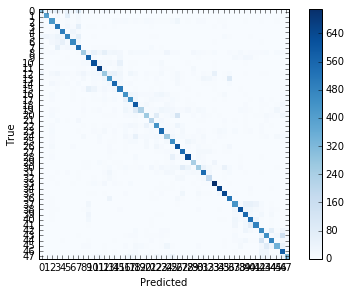

In [71]:
cls_true = b[160000:]
cls_pred = sess.run(tf.argmax(predictions, 1), feed_dict=test_feed_dict)
cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)        

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.tight_layout()
plt.colorbar()
tick_marks = np.arange(48)
plt.xticks(tick_marks, range(48))
plt.yticks(tick_marks, range(48))
plt.xlabel('Predicted')
plt.ylabel('True')

In [72]:
for i in range(48):
    print("[Accuracy: {:>.5f}] {}".format(cm[i][i] / d[i], c[i]))

[Accuracy: 0.38642] IT/과학-IT 일반
[Accuracy: 0.74674] IT/과학-게임/리뷰
[Accuracy: 0.65077] IT/과학-과학 일반
[Accuracy: 0.75888] IT/과학-모바일
[Accuracy: 0.88193] IT/과학-보안/해킹
[Accuracy: 0.64324] IT/과학-인터넷/SNS
[Accuracy: 0.73095] IT/과학-컴퓨터
[Accuracy: 0.75138] IT/과학-통신/뉴미디어
[Accuracy: 0.34459] 경제-경제 일반
[Accuracy: 0.82096] 경제-글로벌 경제
[Accuracy: 0.73498] 경제-금융
[Accuracy: 0.86606] 경제-부동산
[Accuracy: 0.35535] 경제-산업/재계
[Accuracy: 0.56604] 경제-생활경제
[Accuracy: 0.75272] 경제-중기/벤처
[Accuracy: 0.69806] 경제-증권
[Accuracy: 0.66317] 사회-교육
[Accuracy: 0.65075] 사회-노동
[Accuracy: 0.80270] 사회-사건사고
[Accuracy: 0.36581] 사회-사회일반
[Accuracy: 0.39552] 사회-식품/의료
[Accuracy: 0.66154] 사회-언론
[Accuracy: 0.66208] 사회-인권/복지
[Accuracy: 0.73404] 사회-인물
[Accuracy: 0.46279] 사회-지역
[Accuracy: 0.73301] 사회-환경
[Accuracy: 0.79581] 생활/문화-건강정보
[Accuracy: 0.82530] 생활/문화-공연/전시
[Accuracy: 0.83620] 생활/문화-날씨
[Accuracy: 0.69565] 생활/문화-도로/교통
[Accuracy: 0.38889] 생활/문화-생활문화 일반
[Accuracy: 0.73226] 생활/문화-여행/레저
[Accuracy: 0.65428] 생활/문화-음식/맛집
[Accuracy: 0.87315] 생활/문화-자동